## Post-processing Interferograms from ALOS-2

In [3]:
%matplotlib inline
import os
import numpy as np
import platform
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut, isce_utils
from mintpy.cli import view, subset, prep_isce, mask, geocode
from PIL import Image, ImageDraw
from skimage.transform import resize

cmy = pp.ColormapExt('cmy').colormap

#dname = 'ALOS2_A183_20190918_20230215';  sub_str = '-x 0 4500'
dname = 'ALOS2_A184_20220905_20230220';  sub_str = '-y 3000 8000'
#dname = 'ALOS2_D077_20220916_20230217';  sub_str = '-y 500 5500'

proj_dir = os.path.expanduser('~/data/2023TurkeyEQ' if platform.system() == 'Linux' else '~/data/archives/2023TurkeyEQ')
work_dir = os.path.join(proj_dir, dname, 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input/output files
date1, date2 = ptime.yymmdd(dname.split('_')[-2:])
fbase = f'{date1}-{date2}_5rlks_28alks'

int_file = f'filt_{fbase}.int'
cor_file = f'filt_{fbase}.cor'
unw_file = f'filt_{fbase}.unw'
lat_file = f'{fbase}.lat'
lon_file = f'{fbase}.lon'
wbd_file = f'{fbase}.wbd'
msk_file = f'{fbase}.msk'

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar


## [skip] 1. Ionospheric correction (using results from previous setup)

Skip as the fringe in the near field is not very dense for L-band ALOS-2 anymore, thus, the default 5 x 28 looks from `isce2/alos2App` still work.

In [43]:
# input files
int_ori_file = 'diff_190918-230215_2rlks_14alks_ori.int'
ion_file     = '../ion/ion_cal/filt_ion_80rlks_448alks.ion'

# read
int_ori, atr = readfile.read(int_ori_file, datasetName='complex')
ion, atr_ion = readfile.read(ion_file)

# resample ionospheric phase
ion_new = resize(ion, int_ori.shape, order=1, mode='constant', anti_aliasing=True, preserve_range=True)

# correct interferogram
int_cor = int_ori * np.exp(-1j*ion_new)

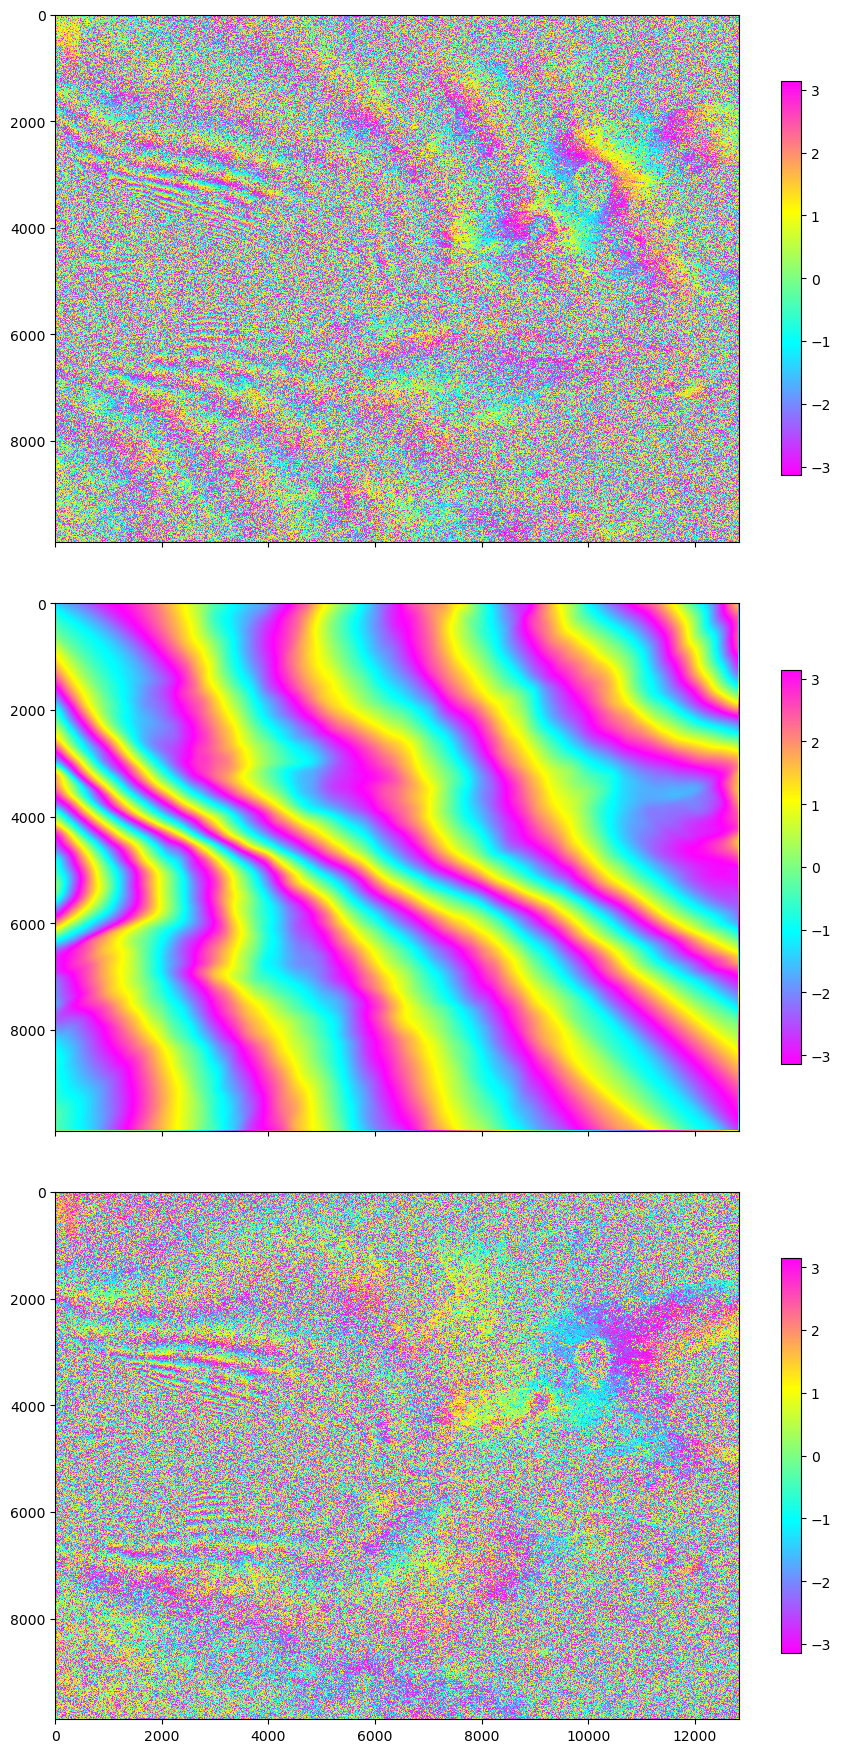

In [45]:
# plot
kwargs = dict(vmin=-np.pi, vmax=np.pi, cmap=pp.ColormapExt('cmy').colormap, interpolation='nearest')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 18], sharex=True)
im = axs[0].imshow(np.angle(int_ori), **kwargs);  fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(ut.wrap(ion_new),  **kwargs);  fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow(np.angle(int_cor), **kwargs);  fig.colorbar(im, ax=axs[2], shrink=0.7)
fig.tight_layout()
plt.show()

In [46]:
# write corrected interferogram [by overwriting the existing file]
int_file = 'diff_190918-230215_2rlks_14alks.int'
print(f'writing file: {int_file}')
int_cor.tofile(int_file)

writing file: diff_190918-230215_2rlks_14alks.int


## [skip] 2. Interferogram filtering + geocode + coherence estimation

### 2.1 re-run filtering via `alos2App.py`

```bash
cd ~/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215
alos2App.py alos2App.xml --steps --dostep=filt
```

### 2.2 Geocode interferogram + coherence estimation

In [80]:
#!prep_isce.py -f filt_190918-230215_2rlks_14alks.int -m ./../190918.track.xml -g ./
!geocode.py filt_190918-230215_2rlks_14alks.int --lat-file 190918-230215_2rlks_14alks.lat --lon-file 190918-230215_2rlks_14alks.lon
isce_utils.estimate_coherence('geo_filt_190918-230215_2rlks_14alks.int', 'geo_filt_190918-230215_2rlks_14alks.cor')

No lookup table (longitude or rangeCoord) found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: 190918-230215_2rlks_14alks.lat
calculate output pixel size using option 1 (same pixel area before/after resampling)
output pixel size in (lat, lon) in degree: (-0.0002666413056464435, 0.00039686341342079127)
output area extent in (S, N, W, E) in degree: (36.18023161869967, 39.9041440933579, 36.076293877863606, 40.76166333670947)
output file row / column number: (13966, 11806)
[1/1] preparing geometry for dest_box: (0, 0, 11806, 13966) --> full src_box: (0, 0, 12822, 9891)
--------------------------------------------------
resampling file: filt_190918-230215_2rlks_14alks.int
--------------------------------------------------1/1
reading complex in block (0, 0, 12822, 9891) from filt_190918-230215_2rlks_14alks.int ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 166 segments ...
write file: geo_filt

## 3. Phase unwrapping

### 3.1 Subset

In [35]:
# go to sub directory
!mkdir -p sub
os.chdir(os.path.join(work_dir, 'sub'))
print('Go to directory:', os.path.join(work_dir, 'sub'))

# subset int file
subset.main(f'../{int_file} {sub_str} -o ./{int_file}'.split())

# subset geometry files
for fext in ['hgt', 'ion', 'lat', 'lon', 'los', 'wbd']:
    fname = f'{fbase}.{fext}'
    subset.main(f'../{fname} {sub_str} -o ./{fname}'.split())

# prepare meta and cor file
prep_isce.main(f'-f {int_file} -m ../../2*.track.xml -g ../'.split())
isce_utils.estimate_coherence(int_file, cor_file)

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215/insar/sub
------------------------------
subset .int file: ../filt_190918-230215_5rlks_28alks.int ...
data   range in (x0,y0,x1,y1): (0, 0, 5129, 4945)
subset range in (x0,y0,x1,y1): (0, 0, 4500, 4945)
data   range in (W, N, E, S): None
subset range in (W, N, E, S): None
writing >>> ./filt_190918-230215_5rlks_28alks.int
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/4500/4945
reading complex in (0, 0, 4500, 4945) from filt_190918-230215_5rlks_28alks.int ...
write file: ./filt_190918-230215_5rlks_28alks.int
write file: ./filt_190918-230215_5rlks_28alks.int.rsc
write file: ./filt_190918-230215_5rlks_28alks.int.xml
write file: ./filt_190918-230215_5rlks_28alks.int.vrt
------------------------------
subset .hgt file: ../190918-230215_5rlks_28alks.hgt ...
data   range in (x0,y0,x1,y1): (0, 0, 5129, 4945)
subset range in (x0,y0,x1,y1): (0, 0, 4500, 4945)
data   range in (W, N, E, S): No

### 3.2 Generate mask for EQ ruptures

+ exclude fault rupture traces
+ [skip] exclude water body. Skipped as water body is not large & not in the near field -> not a problem for PU.
+ [skip] exclude very low coherent pixels. Skipped to let SNAPHU handle it.

#### 3.2.1 Exclude pixels near the fault ruptures

In [1]:
def generate_mask4earthquake_rupture(gmt_lonlat_files, lookup_files, msk_file):
    work_dir = os.path.dirname(msk_file)
    # go to work directory
    os.chdir(work_dir)
    print('Go to directory:', work_dir)

    # read EQ rupture trace files
    faults_lola = []
    for gmt_lonlat_file in gmt_lonlat_files:
        faults_lola += readfile.read_gmt_lonlat_file(gmt_lonlat_file, min_dist=0)

    # translate lat/lon into local X/Y coordinates
    atr = readfile.read_attribute(lookup_files[0])
    coord = ut.coordinate(atr, lookup_file=lookup_files)
    faults_xy = []
    num_fault = len(faults_lola)
    prog_bar = ptime.progressBar(maxValue=num_fault)
    for i, fault_lola in enumerate(faults_lola):
        prog_bar.update(i+1, suffix=f'fault {i+1}/{num_fault}')
        # translate point-by-point to keep faults with partial points outside of the coverage
        fault_xy = []
        for j in range(fault_lola.shape[0]):
            try:
                y, x = coord.geo2radar(fault_lola[j,1], fault_lola[j,0])[:2]
                fault_xy.append((x, y))
            except:
                pass
        if fault_xy:
            faults_xy.append(fault_xy)
    prog_bar.close()

    # rasterize
    # link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    img = Image.new('L', (int(width), int(length)), 1)
    for i, fault_xy in enumerate(faults_xy):
        ImageDraw.Draw(img).line(fault_xy, fill=0, width=20, joint='curve')
    msk = np.array(img, dtype=np.bool_)

    # write to file
    meta = dict(atr)
    meta['FILE_TYPE'] = '.msk'
    meta['DATA_TYPE'] = 'bool'
    meta['BANDS'] = 1
    writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=cor_file)

    # plot
    fig, axs = plt.subplots(figsize=[16, 8])
    ax = axs[0]
    for i, fault in enumerate(faults_lola):
        ax.plot(fault[:,0], fault[:,1], label=i+1)
    ax.set_aspect('equal')
    ax.legend(ncol=3)

    ax = axs[1]
    im = ax.imshow(msk, cmap='gray', interpolation='nearest')
    pp.auto_flip_direction(atr, ax=ax)
    fig.colorbar(im, ax=ax, shrink=0.5)
    plt.show()

In [2]:
gmt_lonlat_files = [os.path.join(proj_dir, f'USGS/simple_fault_{x}.lonlat') for x in ['confident', 'queried']]
generate_mask4earthquake_rupture(gmt_lonlat_files, lookup_files=[lat_file, lon_file], msk_file=msk_file)

NameError: name 'os' is not defined

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215/insar/sub


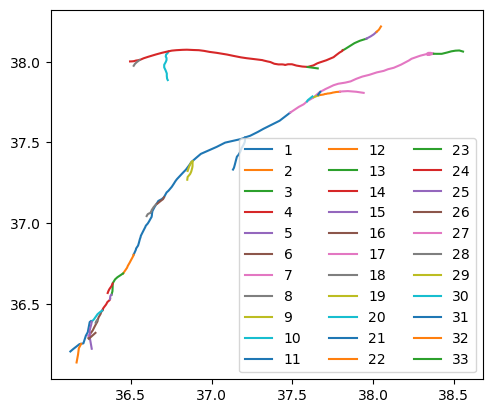

In [2]:
# go to sub directory
os.chdir(os.path.join(work_dir, 'sub'))
print('Go to directory:', os.path.join(work_dir, 'sub'))

# read 
faults_lola  = readfile.read_gmt_lonlat_file(os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat'), min_dist=0)
faults_lola += readfile.read_gmt_lonlat_file(os.path.join(proj_dir, 'USGS/simple_fault_queried.lonlat'), min_dist=0)
# plot
fig, ax = plt.subplots()
for i, fault in enumerate(faults_lola):
    ax.plot(fault[:,0], fault[:,1], label=i+1)
ax.set_aspect('equal')
ax.legend(ncol=3)
plt.show()

In [3]:
# translate lat/lon into local X/Y coordinates
atr = readfile.read_attribute(int_file)
coord = ut.coordinate(atr, lookup_file=[lat_file, lon_file])
faults_xy = []
num_fault = len(faults_lola)
prog_bar = ptime.progressBar(maxValue=num_fault)
for i, fault_lola in enumerate(faults_lola):
    prog_bar.update(i+1, suffix=f'fault {i+1}/{num_fault}')
    # translate point-by-point to keep faults with partial points outside of the coverage
    fault_xy = []
    for j in range(fault_lola.shape[0]):
        try:
            y, x = coord.geo2radar(fault_lola[j,1], fault_lola[j,0])[:2]
            fault_xy.append((x, y))
        except:
            pass
    if fault_xy:
        faults_xy.append(fault_xy)
prog_bar.close()

[=>                       3%                       ] fault 1/33    0s /     0s

/home/zhangyunjun/tools/mambaforge/envs/insar/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhangyunjun/tools/mambaforge/envs/insar/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[==================================================] fault 33/33   48s /     1s 


ASCENDING orbit -> flip up-down


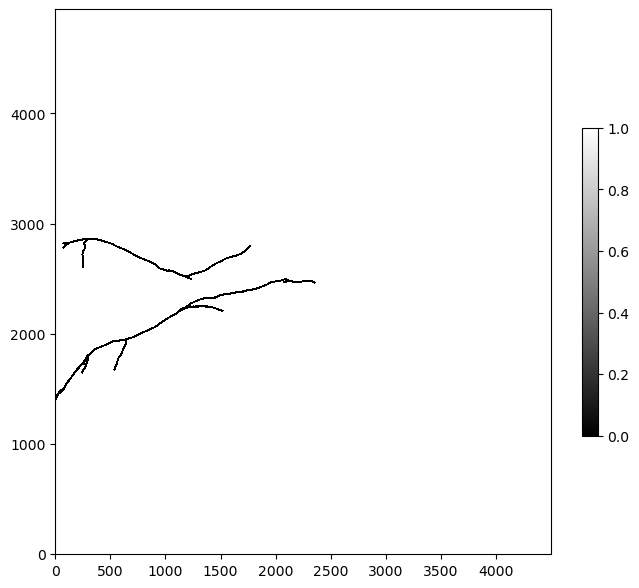

In [4]:
# rasterize
# link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
atr = readfile.read_attribute(int_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

img = Image.new('L', (int(width), int(length)), 1)
for i, fault_xy in enumerate(faults_xy):
    ImageDraw.Draw(img).line(fault_xy, fill=0, width=20, joint='curve')
msk = np.array(img, dtype=np.bool_)

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
pp.auto_flip_direction(atr, ax=ax)
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

#### [skip] 3.2.2 Exclude pixels on water

In [ ]:
# generate water body file in geo-coordinates
#!prep_isce.py -f 190918-230215_2rlks_14alks.wbd -m ./../190918.track.xml -g ./
#!geocode.py 190918-230215_2rlks_14alks.wbd --lat-file 190918-230215_2rlks_14alks.lat --lon-file 190918-230215_2rlks_14alks.lon

# update mask based on water body
wbd = readfile.read(wbd_file)[0]
msk[wbd!=0] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
pp.auto_flip_direction(atr, ax=ax)
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

#### [skip] 3.2.3 Exclude pixels with low coherence

In [ ]:
# update mask based on water body
cor, meta = readfile.read(cor_file)
cor[cor == 0] = np.nan
#msk[water_body!=0] = 0

# stats on the coherence
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 2.5])
im = ax.hist(cor.flatten(), bins=50)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('coherence')

# update mask based on coherence
msk[cor < 0.25] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

#### 3.2.4 Write mask file

In [5]:
meta = dict(atr)
meta['FILE_TYPE'] = '.msk'
meta['DATA_TYPE'] = 'bool'
meta['BANDS'] = 1
writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=cor_file)

write file: 190918-230215_5rlks_28alks.msk
write file: 190918-230215_5rlks_28alks.msk.rsc


'190918-230215_5rlks_28alks.msk'

### 3.3 Re-run phase unwrapping

In [27]:
print(f'cd {os.path.join(work_dir, "sub")}')
print(f'screen -S {dname.split("_")[1]}_UNW -L\nload_insar')
cmd = f'unwrap.py -i {int_file} -c {cor_file} -o {unw_file} --mask {msk_file} '
cmd += '--max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO '
print(cmd)

cd /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215/insar/sub
screen -S A183_UNW -L
load_insar
unwrap.py -i filt_190918-230215_5rlks_28alks.int -c filt_190918-230215_5rlks_28alks.cor -o filt_190918-230215_5rlks_28alks.unw --mask 190918-230215_5rlks_28alks.msk --max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO 


## 4. Mask and geocode

Copy files from `insar/sub` on cluster to `insar` on laptop.

In [35]:
work_dir = os.path.join(proj_dir, dname, 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# mask
#mask.main(f'{unw_file}.conncomp -m {wbd_file} --mask-vmax 1 --fill 0'.split())
#mask.main(f'{unw_file} -m {unw_file}_msk.conncomp'.split())

# geocode
S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
step = 0.000833334   # deg (90 m)     # set to None to calculate product resolution for reference
!mkdir -p geo

opt = f'--lat-file {lat_file} --lon-file {lon_file} --fill nan --bbox {S} {N} {W} {E} --lalo-step -{step} {step}'
geocode.main(f'filt_{fbase}_msk.unw -o ./geo/geo_filt_msk.unw {opt}'.split())
#geocode.main(f'filt_{fbase}.cor -o ./geo/geo_filt.cor {opt}'.split())
#geocode.main(f'{fbase}.los -o ./geo/los.geo {opt}'.split())

# spatial reference
#!reference_point.py ./geo/geo_filt_msk.unw --lat 36.3 --lon 38.5

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000833334, 0.000833334)
output area extent in (S, N, W, E) in degree: (35.29999704, 39.0, 35.0, 39.5000036)
output file row / column number: (4440, 5400)
[1/1] preparing geometry for dest_box: (0, 0, 5400, 4440) --> full src_box: (0, 0, 5141, 5000)
--------------------------------------------------
resampling file: filt_220905-230220_5rlks_28alks_msk.unw
--------------------------------------------------1/1
reading magnitude in block (0, 0, 5141, 5000) from filt_220905-230220_5rlks_28alks_msk.unw ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 25 segments ...
--------------------------------------------------1/1
reading phase     in block (0, 0, 5141, 5000) from filt_220905-230220_5rlks_28a

## 5. Correct for troposphere and solid Earth tides

In [27]:
from mintpy.cli import load_data, smallbaselineApp
# write geometry HDF5 file
config = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = {os.path.join(proj_dir, dname, f'{date1}.track.xml')}
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = {os.path.join(work_dir, f'{fbase}.hgt')}
mintpy.load.lookupYFile      = {os.path.join(work_dir, f'{fbase}.lat')}
mintpy.load.lookupXFile      = {os.path.join(work_dir, f'{fbase}.lon')}
mintpy.load.incAngleFile     = {os.path.join(work_dir, f'{fbase}.los')}
mintpy.load.azAngleFile      = {os.path.join(work_dir, f'{fbase}.los')}
"""
sname, oname = dname.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())
# write geometryGeo.h5
geocode.main(f'./inputs/geometryRadar.h5 -o ./geo/geometryGeo.h5 {opt}'.split())

write MintPy configuration to file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/ALOS2_A184.txt
--------------------------------------------------
Project name: ALOS2_A184
Go to work directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar
read custom template file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/ALOS2_A184.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/smallbaselineApp.cfg
copy ALOS2_A184.txt       to inputs   directory for backup.
copy ALOS2_A184.txt       to pic      directory for backup.
read default template file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/smallbaselineApp.cfg
Go back to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar

######################################

In [33]:
!tropo_pyaps3.py -f ./geo/geo_filt_msk.unw -g ./geo/geometryGeo.h5

weather model: ERA5 - dry (hydrostatic) and wet delay
weather directory: /Users/yunjunz/data/aux
output tropospheric delay     time-series file: ./geo/ERA5.h5
output corrected displacement time-series file: ./geo/geo_filt_msk_ERA5.unw
read dates/time info from file: ./geo/geo_filt_msk.unw
time of cloest available product: 21:00 UTC

--------------------------------------------------------------------------------
Download global atmospheric model files...
update mode: ON
output file: ./geo/ERA5.h5
1) output file either do NOT exist or is NOT newer than all GRIB files.
run or skip: run
--------------------------------------------------
downloading weather model data using PyAPS ...
number of grib files to download: 2
--------------------------------------------------
INFO: You are using the latest ECMWF platform for downloading datasets: https://cds.climate.copernicus.eu/api/v2
{'product_type': 'reanalysis', 'format': 'grib', 'variable': ['geopotential', 'temperature', 'specific_humidity